# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [10]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random
import pandas as pd

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [798]:
class Perceptron:
    def __init__(self, iterations=100):
        self.w = []
        self.iterations = iterations
    
    def fit(self, X, y):
        X = pd.DataFrame(X)
        self.w = [0, 1, -1]
        for i in range(self.iterations):
            j = 0
            while self.predict(X.iloc[j]) == y[j]:
                j += 1
            sign = 1 if y[j] else -1
            self.w += sign*np.array([[1] + list(np.array(X.iloc[j]))]).flatten()
    def predict(self, X):
        ans = []
        X = pd.DataFrame(X)
        if X.shape[1] == 1: 
            ans = 1 if np.dot(np.array(self.w), np.array([[1] + list(np.array(X))]).flatten()) > 0 else 0
        else:
            for i in range(X.shape[0]):
                ans.append(1 if np.dot(np.array(self.w), np.array([[1] + list(np.array(X.iloc[i]))]).flatten()) > 0 else 0)
        return ans

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

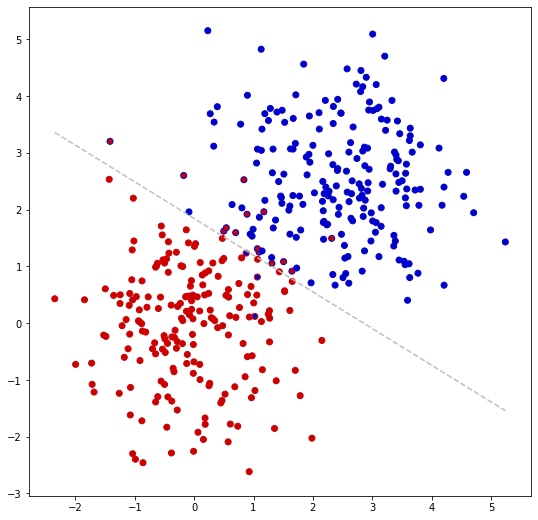

In [701]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

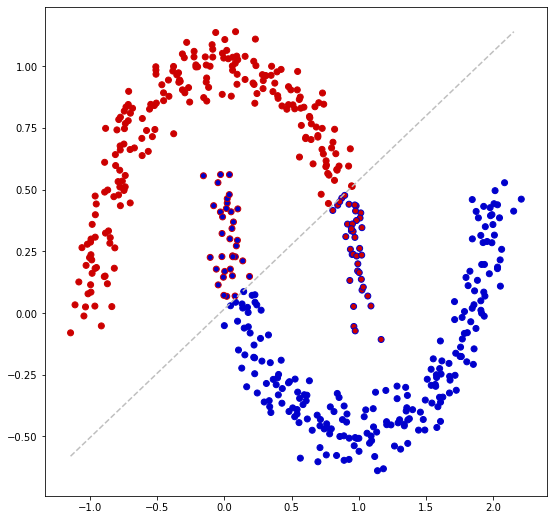

In [309]:
X, true_labels = make_moons(500, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [792]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.w = []
        self.iterations = iterations
    
    def fit(self, X, y):
        X = pd.DataFrame(X)
        self.best_w, best_res = self.w, 0
        for i in range(X.shape[1] + 1):
            self.w.append(random.uniform(0, 1))
        for i in range(self.iterations):
            res = 0
            j = 0
            while self.predict(X.iloc[j]) == y[j]:
                j += 1
            sign = 1 if y[j] else -1
            self.w += sign*np.array([[1] + list(np.array(X.iloc[j]))]).flatten()
            res = list(np.array(self.predict(X)) == np.array(y)).count(True)
            if res > best_res:
                best_res = res
                self.best_w = self.w
            
    def predict(self, X, flag=0):
        ans = []
        X = pd.DataFrame(X)
        if X.shape[1] == 1: 
            ans = 1 if np.dot(np.array(self.w), np.array([[1] + list(np.array(X))]).flatten()) > 0 else 0
        else:
            if not flag:
                for i in range(X.shape[0]):
                    ans.append(1 if np.dot(np.array(self.w), np.array([[1] + list(np.array(X.iloc[i]))]).flatten()) > 0 else 0)
            else:
                for i in range(X.shape[0]):
                    ans.append(1 if np.dot(np.array(self.best_w), np.array([[1] + list(np.array(X.iloc[i]))]).flatten()) > 0 else 0)
        return ans

In [685]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

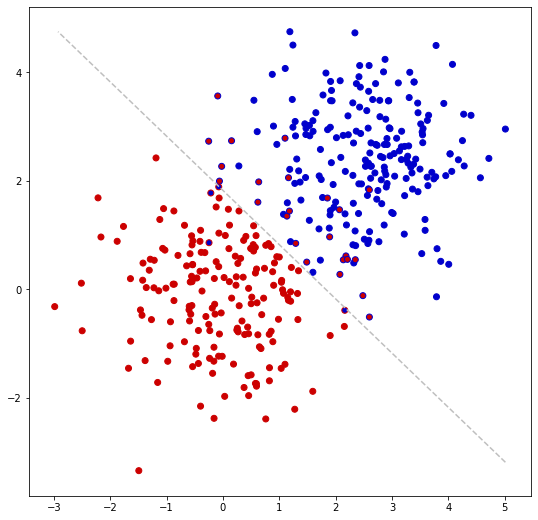

In [484]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X, 1)), c.w)

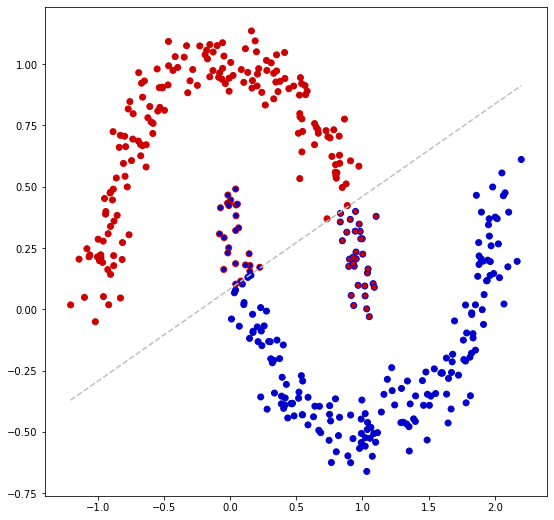

In [377]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

первый признак - сумма всех значений пикселей картинки

второй признак - количество пикселей с цветом > 0.1, которые находятся по краям картинки

In [774]:
def transform_images(images):
    ans = []
    for image in images:
        cnt_black = 0
        concentration = 0
        for i in range(len(image)):
            for j in range(len(image[0])):
                concentration += image[i][j]
                if image[i][j] > 0.1 and (i < 3) and (j > 6 or j < 3):
                    cnt_black += 1
        ans.append(np.array([concentration, cnt_black]))
    return np.array(ans)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [775]:
X, y = get_digits()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
for i in range(len(y_train)):
    if y_train[i] == 5:
        y_train[i] = 0
for i in range(len(y_test)):
    if y_test[i] == 5:
        y_test[i] = 0

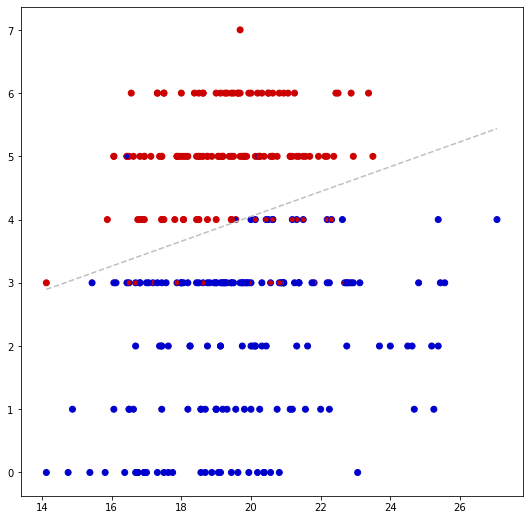

Accuracy: 0.7945205479452054


In [776]:
c = Perceptron(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, c.predict(X_train), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

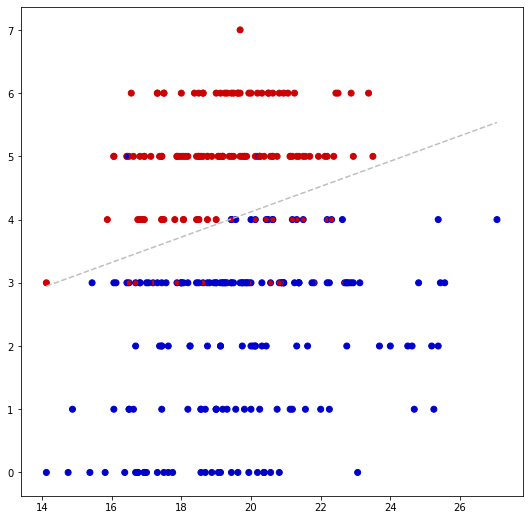

Accuracy: 0.8082191780821918


In [777]:
c = PerceptronBest(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, c.predict(X_train, 1), c.w)
print("Accuracy:", np.mean(c.predict(X_test, 1) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [799]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    uni = np.unique(y)
    for i in range(len(y)):
        if y[i] == uni[0]:
            y[i] = 0
        else:
            y[i] = 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=200)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.554671611607749


In [801]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    uni = np.unique(y)
    for i in range(len(y)):
        if y[i] == uni[0]:
            y[i] = 0
        else:
            y[i] = 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=50)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.5073660209183395
